In [3]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib import rcParams
from matplotlib import pyplot as plt

sns.set()
rcParams['figure.figsize'] = 20, 20

In [4]:
#constants
MAX_RESULT_LIST_LENGTH = 1000
DIRICHLET_SAMPLE_DRAWS = 20

In [5]:
# for every list output, the list score is, the presence of an advertisement (denoted by adv = 1)
# and a product of its click rate and rank

def score_list(df):
    score = np.sum(df['click_probability'] * df['adv'] * 1/df['id'])/(np.sum(df['adv'])+1)
    return score

In [6]:
# 4 possible rankings Algorithms 
# each one is basically a dataframe with 2 columns
# id and probability of clicks
d = []
for srp_ct in range(1, 200):
    rank_A  = pd.DataFrame({ 'id' : pd.Series(range(1,MAX_RESULT_LIST_LENGTH+1)),
                            'click_probability' : pd.Series([np.random.uniform( 0.3, 1 ) for i in range(MAX_RESULT_LIST_LENGTH)]),
                            'adv' : pd.Series(np.random.randint(0,2, size=MAX_RESULT_LIST_LENGTH))
                              })

    rank_B  = pd.DataFrame({ 'id' : pd.Series(range(1,MAX_RESULT_LIST_LENGTH+1)),
                            'click_probability' : pd.Series(np.random.random_sample((MAX_RESULT_LIST_LENGTH,))),
                            'adv' : pd.Series(np.random.randint(0,2, size=MAX_RESULT_LIST_LENGTH))
                              })


    rank_C  = pd.DataFrame({ 'id' : pd.Series(range(1,MAX_RESULT_LIST_LENGTH+1)),
                            'click_probability' : pd.Series([np.random.uniform( 0.01, 0.6 ) for i in range(MAX_RESULT_LIST_LENGTH)]),
                            'adv' : pd.Series(np.random.randint(0,2, size=MAX_RESULT_LIST_LENGTH))
                              })
    
    rank_D  = pd.DataFrame({ 'id' : pd.Series(range(1,MAX_RESULT_LIST_LENGTH+1)),
                            'click_probability' : pd.Series([np.random.uniform( 0.02, 0.8 ) for i in range(MAX_RESULT_LIST_LENGTH)]),
                            'adv' : pd.Series(np.random.randint(0,2, size=MAX_RESULT_LIST_LENGTH))
                              })

    # score of algorithms 
    rank_A_score = score_list(df = rank_A)
    rank_B_score = score_list(df = rank_B)
    rank_C_score = score_list(df = rank_C)
    rank_D_score = score_list(df = rank_D)
    
    d.append({'srp_ct': srp_ct, 'type': 'Algo_1', 'val': rank_A_score })
    d.append({'srp_ct': srp_ct, 'type': 'Algo_2', 'val': rank_B_score })
    d.append({'srp_ct': srp_ct , 'type': 'Algo_3', 'val': rank_C_score })
    d.append({'srp_ct': srp_ct , 'type': 'Algo_4', 'val': rank_D_score })

    
final = pd.DataFrame(d)

In [7]:

rank_D.head(5)

,id,click_probability,adv
0,1,0.518473,0
1,2,0.210659,1
2,3,0.429595,0
3,4,0.739144,1
4,5,0.031554,1


In [8]:

final.head(3)


,srp_ct,type,val
0,1,Algo_1,0.003901
1,1,Algo_2,0.004013
2,1,Algo_3,0.003672


Text(0, 0.5, 'Algorithm Value')

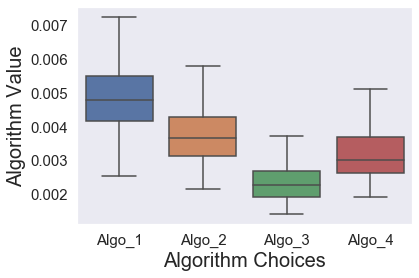

In [9]:
# SRP for each Algorithm boxplt
sns.set_style("dark")
sns.boxplot(x = final['type'], y = final['val'], data=final)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Algorithm Choices", fontsize=20)
plt.ylabel("Algorithm Value", fontsize=20)

C:\Users\zakel\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\zakel\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


([], <a list of 0 Text xticklabel objects>)

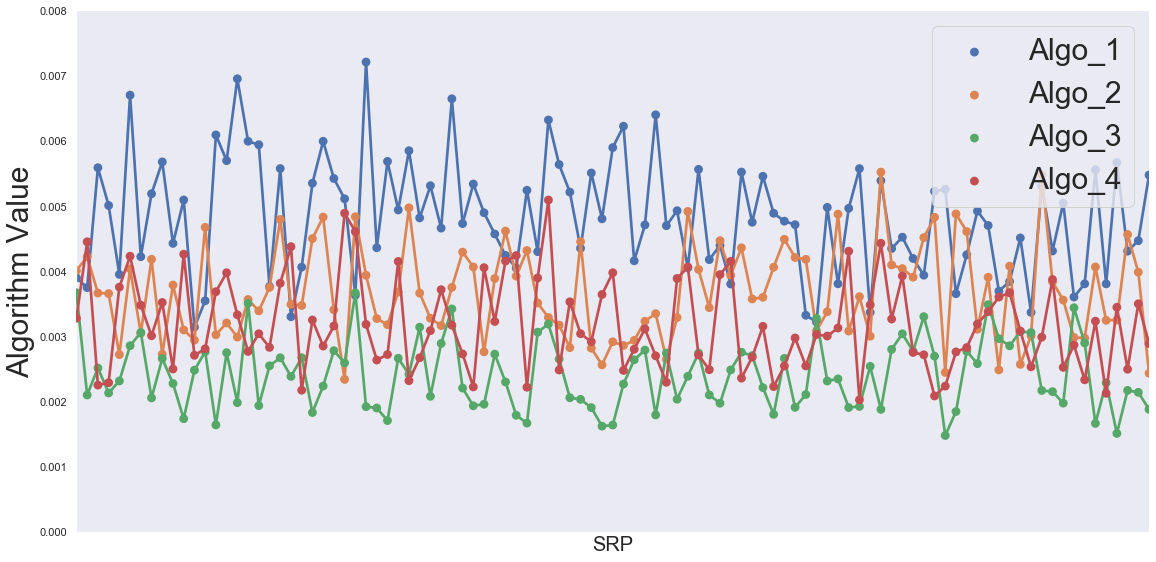

In [12]:

sns.factorplot(x="srp_ct", y="val", hue="type", data=final, size=8, aspect=2, legend=False)
plt.xlim([0, 100])
plt.ylim([0, 0.008])
plt.xlabel("SRP", fontsize=20)
plt.ylabel("Algorithm Value", fontsize=30)
plt.legend(loc='upper right', fontsize=30)
plt.xticks([])

In [23]:

mean_algo_vals = pd.DataFrame(final.groupby(['type'])['val'].median()).reset_index()
mean_algo_vals

,type,val
0,Algo_1,0.008658
1,Algo_2,0.006541
2,Algo_3,0.004135
3,Algo_4,0.005353


In [26]:

bandit_probs = [i/np.sum(list(mean_algo_vals['val'])) for i in list(mean_algo_vals['val'])] # bandit probabilities of success
N_bandits = len(bandit_probs)


N_episodes=10000


N_experiments = 100

bandit_probs

[0.3507080951755355,
 0.2649422022745079,
 0.1675083480646977,
 0.21684135448525885]

In [27]:
# create bandit
class Bandit:
    def __init__(self, bandit_probs):
        self.N = len(bandit_probs)  # number of bandits
        self.prob = bandit_probs  # success probabilities for each bandit

    # Get reward (1 for success, 0 for failure)
    def get_reward(self, action):
        rand = np.random.random()  # [0.0,1.0)
        reward = 1 if (rand < self.prob[action]) else 0
        return reward

In [28]:
# create agent
class Agent:
    #    Update Q action-value using:
    #     The update action-values Q is =
    #    Q(a) <- Q(a) + 1/(k+1) * (R(a) - Q(a))
    #    where
    #    Q(a) = current value estimate of action "a"
    #    k = number of times action "a" was chosen so far
    #    R(a) = reward of sampling action bandit (bandit) "a"

    def __init__(self, bandit, epsilon):
        self.epsilon = epsilon
        self.k = np.zeros(bandit.N, dtype=np.int)  # number of times action was chosen
        self.Q = np.zeros(bandit.N, dtype=np.float)  # estimated value


    def update_Q(self, action, reward):
        self.k[action] += 1  # update action counter k -> k+1
        self.Q[action] += (1./self.k[action]) * (reward - self.Q[action])

    # exploration function: epsilon-greedy
    def choose_action(self, bandit, force_explore=False):
        rand = np.random.random()  # [0.0,1.0)
        if (rand < self.epsilon) or force_explore:
            action_explore = np.random.randint(bandit.N)  # exploration function
            return action_explore
        else:
            action_greedy = np.random.choice(np.flatnonzero(self.Q == self.Q.max()))
            return action_greedy

In [29]:

def experiment(agent, bandit):
    """
    Given an agent and some bandits how does the playouts occur across each episode.
    
    """
    action_history = []
    reward_history = []
    for episode in range(N_episodes):
        
        # Choose action from agent (from current Q estimate)
        
        action = agent.choose_action(bandit)
        
        # Pick up reward from bandit for chosen action
        reward = bandit.get_reward(action)
        
        # Update Q action-value estimates
        agent.update_Q(action, reward)
        
        # Append to history
        action_history.append(action) # which algo was chosen?
        reward_history.append(reward) # what was the reward?
        
    return (np.array(action_history), np.array(reward_history))

In [14]:
# simulation bandit
def simulate(epsilon):
    print("Running multi-armed bandits with N_bandits = {} and agent epsilon = {}".format(N_bandits, epsilon))
    
    reward_history_avg = np.zeros(N_episodes)  # reward history experiment-averaged
    action_history_sum = np.zeros((N_episodes, N_bandits))  # sum action history

    for i in range(N_experiments):
        bandit = Bandit(bandit_probs)  # initialize bandits
        agent = Agent(bandit, epsilon)  # initialize agent
        
        # perform experiment
        (action_history, reward_history) = experiment(agent, bandit)  

        if (i + 1) % (N_experiments / 2) == 0:
            print("[Experiment {}/{}]".format(i + 1, N_experiments))
            print("  Epsilon = {}".format(epsilon))
                      
            print("  Algo choice history = {}".format(action_history + 1))
            print("  reward history = {}".format(reward_history))
            print("  average reward = {}".format(np.sum(reward_history) / len(reward_history)))
            print("")
            
        # Sum up experiment reward (later to be divided to represent an average)
        reward_history_avg += reward_history
        # Sum up action history
        for j, (a) in enumerate(action_history):
            action_history_sum[j][a] += 1

    reward_history_avg /= np.float(N_experiments)
    #print("reward history avg = {}".format(reward_history_avg))
    
    return  reward_history_avg, action_history_sum

Running multi-armed bandits with N_bandits = 4 and agent epsilon = 0.0
[Experiment 50/100]
  Epsilon = 0.0
[Experiment 100/100]
  Epsilon = 0.0


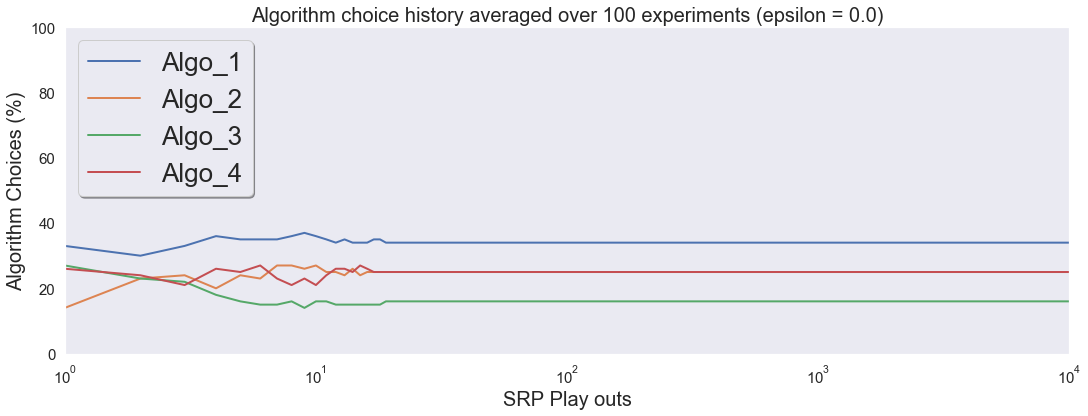

Running multi-armed bandits with N_bandits = 4 and agent epsilon = 0.1
[Experiment 50/100]
  Epsilon = 0.1
[Experiment 100/100]
  Epsilon = 0.1


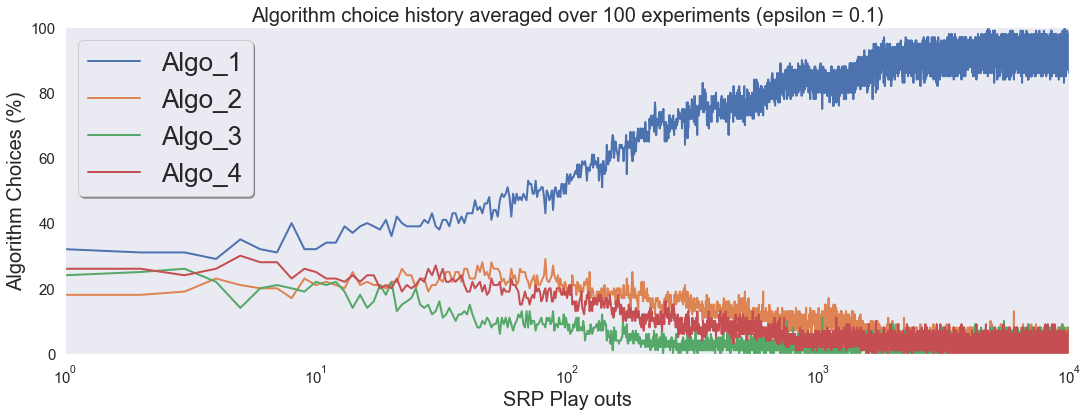

Running multi-armed bandits with N_bandits = 4 and agent epsilon = 0.2
[Experiment 50/100]
  Epsilon = 0.2
[Experiment 100/100]
  Epsilon = 0.2


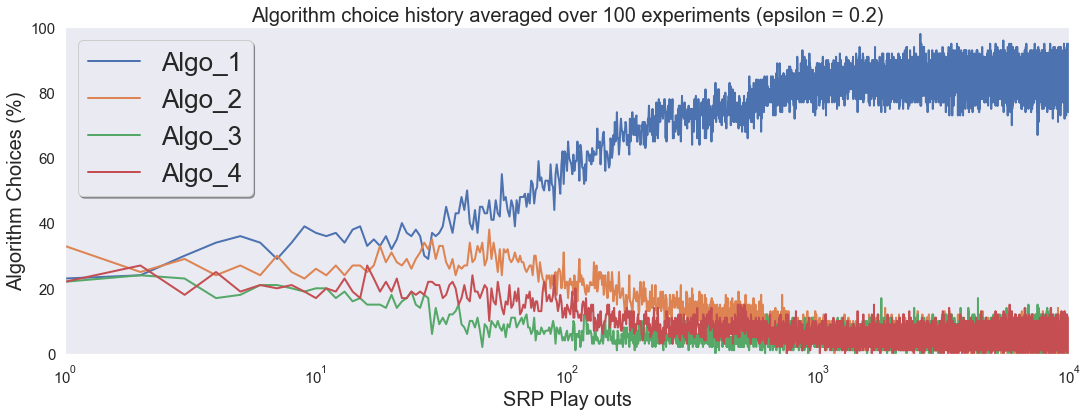

Running multi-armed bandits with N_bandits = 4 and agent epsilon = 0.30000000000000004
[Experiment 50/100]
  Epsilon = 0.30000000000000004
[Experiment 100/100]
  Epsilon = 0.30000000000000004


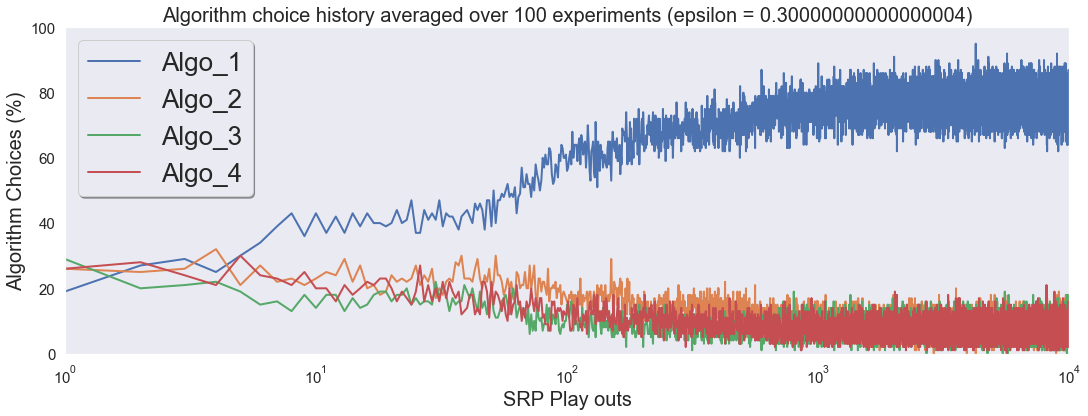

Running multi-armed bandits with N_bandits = 4 and agent epsilon = 0.4
[Experiment 50/100]
  Epsilon = 0.4
[Experiment 100/100]
  Epsilon = 0.4


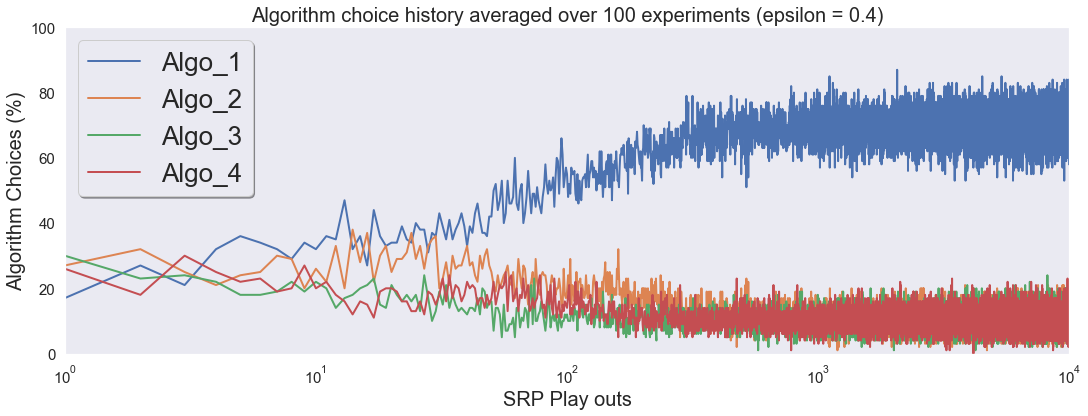

Running multi-armed bandits with N_bandits = 4 and agent epsilon = 0.5
[Experiment 50/100]
  Epsilon = 0.5
[Experiment 100/100]
  Epsilon = 0.5


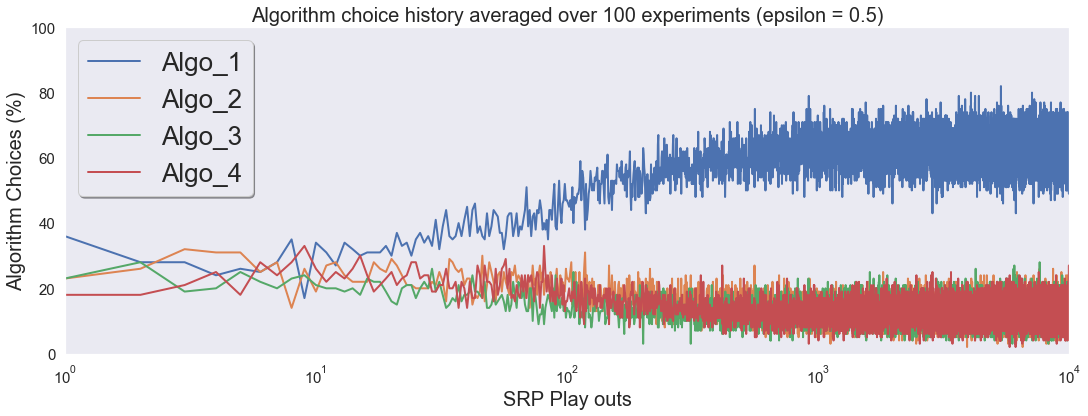

Running multi-armed bandits with N_bandits = 4 and agent epsilon = 0.6000000000000001
[Experiment 50/100]
  Epsilon = 0.6000000000000001
[Experiment 100/100]
  Epsilon = 0.6000000000000001


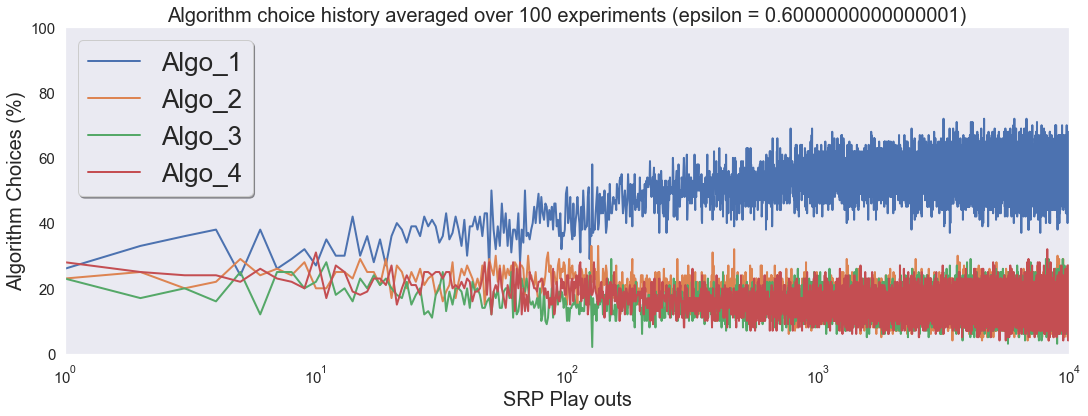

Running multi-armed bandits with N_bandits = 4 and agent epsilon = 0.7000000000000001
[Experiment 50/100]
  Epsilon = 0.7000000000000001
[Experiment 100/100]
  Epsilon = 0.7000000000000001


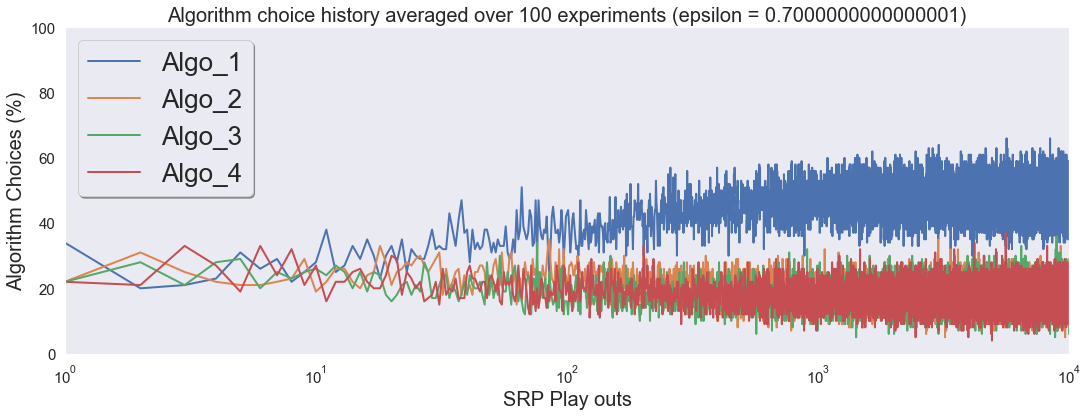

Running multi-armed bandits with N_bandits = 4 and agent epsilon = 0.8
[Experiment 50/100]
  Epsilon = 0.8
[Experiment 100/100]
  Epsilon = 0.8


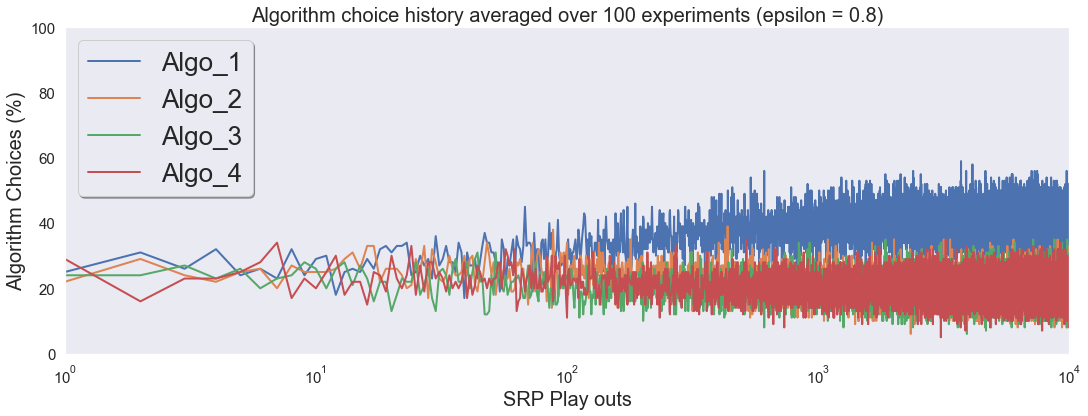

Running multi-armed bandits with N_bandits = 4 and agent epsilon = 0.9
[Experiment 50/100]
  Epsilon = 0.9
[Experiment 100/100]
  Epsilon = 0.9


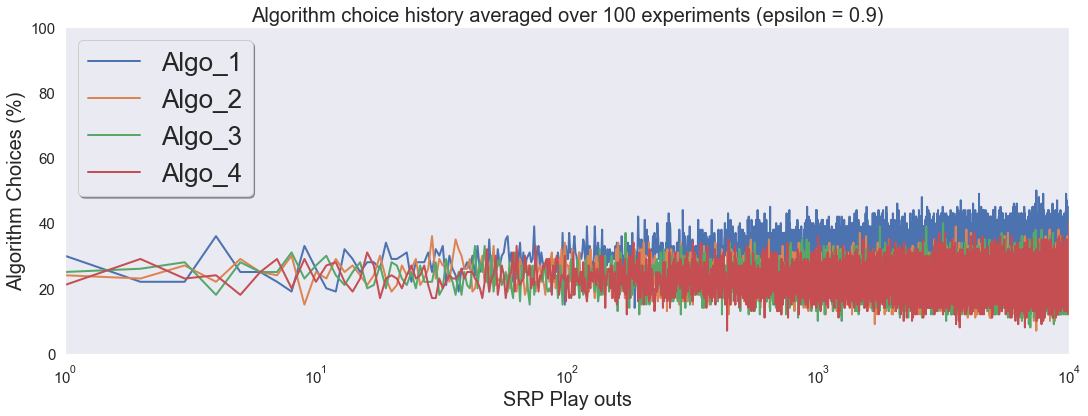

In [31]:
#Run the simulation for different epsilons
for ep in np.arange(0.0, 1.0, 0.1):
    
    
    
    (reward_history_avg, action_history_sum) = simulate(epsilon = ep)
    
    
    # =========================
    # Plot action history results
    # =========================
    plt.figure(figsize=(18, 6))
    for i in range(N_bandits):
        action_history_sum_plot = 100 * action_history_sum[:,i] / N_experiments
        
        plt.plot(list(np.array(range(len(action_history_sum_plot)))+1),
                 action_history_sum_plot,
                 linewidth=2.0,
                 label="Algo_{}".format(i+1))
    plt.title("Algorithm choice history averaged over {} experiments (epsilon = {})".format(N_experiments, ep), fontsize=20)
    plt.xlabel("SRP Play outs", fontsize=20)
    plt.ylabel("Algorithm Choices (%)", fontsize=20)
    leg = plt.legend(loc='upper left', shadow=True, fontsize=26)
    ax = plt.gca()
    ax.set_xscale("log", nonposx='clip')
    ax.set(xscale="log")
    plt.xlim([1, N_episodes])
    plt.ylim([0, 100])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

In [ ]:

run_scores = []    
# check for each run, check the gain in choosing the algorithm
for run_ctr in range(len(action_history_sum_plot)):
    sum = 0
    alpha = []
    
    # iterate the bandits to check the individual likelihood scores
    for i in range(N_bandits):
        action_history_sum_plot = 100 * action_history_sum[:,i] / N_experiments
        prob_choosing_algo_i = action_history_sum_plot[run_ctr]
        alpha.append(prob_choosing_algo_i)
        #print("Algo_{}, has prob {}".format(i+1, prob_choosing_algo_i))  
        sum += prob_choosing_algo_i

    # randomly play out a search result page, following the distribution    
    # debug point, the sum should be 100% at each point
    print("Distribution for this run = {}",format(sum) )
    
    # draw sample from a dirichlet distribution with alphas as parameter    
    # draw N random samples, and for each sample try to
    # for the winner algo, sample a SRP list. 
    # compute the score for that SRP.
    samples_for_this_run = np.random.dirichlet(np.array(alpha), DIRICHLET_SAMPLE_DRAWS)
    srp_score = 0
    for a in samples_for_this_run:
        # in this sample draw, which algo is the winner
        best_algo = 'Algo_' + str(pd.Series(a).idxmax() + 1)
        # grab a sample for this algo
        sample_srp_page = final[final['type'] == best_algo].sample(100)
        srp_score += float(np.max(sample_srp_page['val']))
                
    run_srp_score = srp_score/DIRICHLET_SAMPLE_DRAWS
    run_scores.append(run_srp_score)

In [ ]:
sns.set()
plt.plot(list(np.array(range(len(action_history_sum_plot)))+1),
                 run_scores,
                 linewidth=4.0)
ax = plt.gca()
ax.set_xscale("log", nonposx='clip')
plt.xlim([1, N_episodes])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("SRP Playouts", fontsize=20)
plt.ylabel("Average SRP Score", fontsize=20)
rcParams['figure.figsize'] = 20, 6

In [15]:

AA  = pd.DataFrame({ 'X' : np.log10(pd.Series(list(np.array(range(len(action_history_sum_plot)))+1))),
                    'Y' : run_scores    })

NameError: name 'action_history_sum_plot' is not defined

In [16]:

graph = sns.lmplot('X', 'Y', data = AA, fit_reg=True, order=3, size=9, aspect=2, 
                   scatter_kws={"s": 10}, 
                  line_kws={'color': 'red'})
#graph.set(ylim = (0.0075, 0.0105))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("SRP Playouts (10^x)", fontsize=20)
plt.ylabel("Overall SRP Score", fontsize=20)

NameError: name 'AA' is not defined